***This notebook was created by Antoine Courbi and Thibault Gillard***

The original dataset comes from a set of three datasets from [kaggle](https://www.kaggle.com/datasets/shenba/time-series-datasets/data). The one selected is named Electric_Production and contains yearly electrical production in IPG2211A2N.

#  **Import Libraries**

In [135]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from tqdm import tqdm

from statsmodels.tsa.stattools import adfuller

#  **Import the Data**

In [136]:
df = pd.read_csv('Electric_Production.csv')
df.rename(columns={'DATE':'date','IPG2211A2N':'production'},inplace=True)
df['date'] = pd.to_datetime(df['date'])

In [137]:
df.describe().drop('date',axis=1)

,production
count,396.000000
mean,88.744799
min,55.315100
25%,77.016925
50%,89.768100
75%,100.460050
max,124.254900
std,15.271215


In [138]:
df.set_index('date', inplace=True)

<Axes: xlabel='date', ylabel='production'>

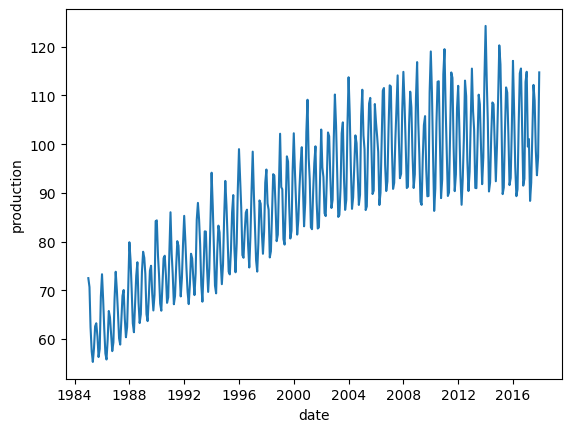

In [139]:
sns.lineplot(data=df,x='date',y='production')

As we can see the data clearly contains a trend and a seasonal component, since we can see yearly fluctuations and a general increase (trend) over the years.

# **Manual Decomposition**

Lets create the decomposition founctions.

In [140]:
def moving_average(a, n=3):
    '''
    The moving average function is used to smooth out the data by averaging the data points of a given window size.
    '''
    a = np.array(a)
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def manual_seasonal_decompose(series, model='additive', period=12):
    '''
    The manual seasonal decomposition function is used to decompose the time series into its components.
    '''
    trend = moving_average(series, period)
    trend = np.pad(trend, (period-1, 0), 'constant', constant_values=np.NaN)

    if model == 'additive':
        detrended = series - trend
        seasonal = detrended.groupby(detrended.index.month).transform('mean')
        resid = detrended - seasonal
    elif model == 'multiplicative':
        detrended = series / trend
        seasonal = detrended.groupby(detrended.index.month).transform('mean')
        resid = detrended / seasonal
    else:
        raise ValueError("model must be either 'additive' or 'multiplicative'")

    return {'observed': series, 'trend': trend, 'seasonal': seasonal, 'resid': resid}

Now we can use them to decompose our serie into the trend, the seasonal and residual components.

In [141]:
manual_decomposition = manual_seasonal_decompose(df['production'], model='additive', period=12)

In [142]:
trend = manual_decomposition['trend']
seasonal = manual_decomposition['seasonal']
residual = manual_decomposition['resid']

Now we can show the manual decomposition results.

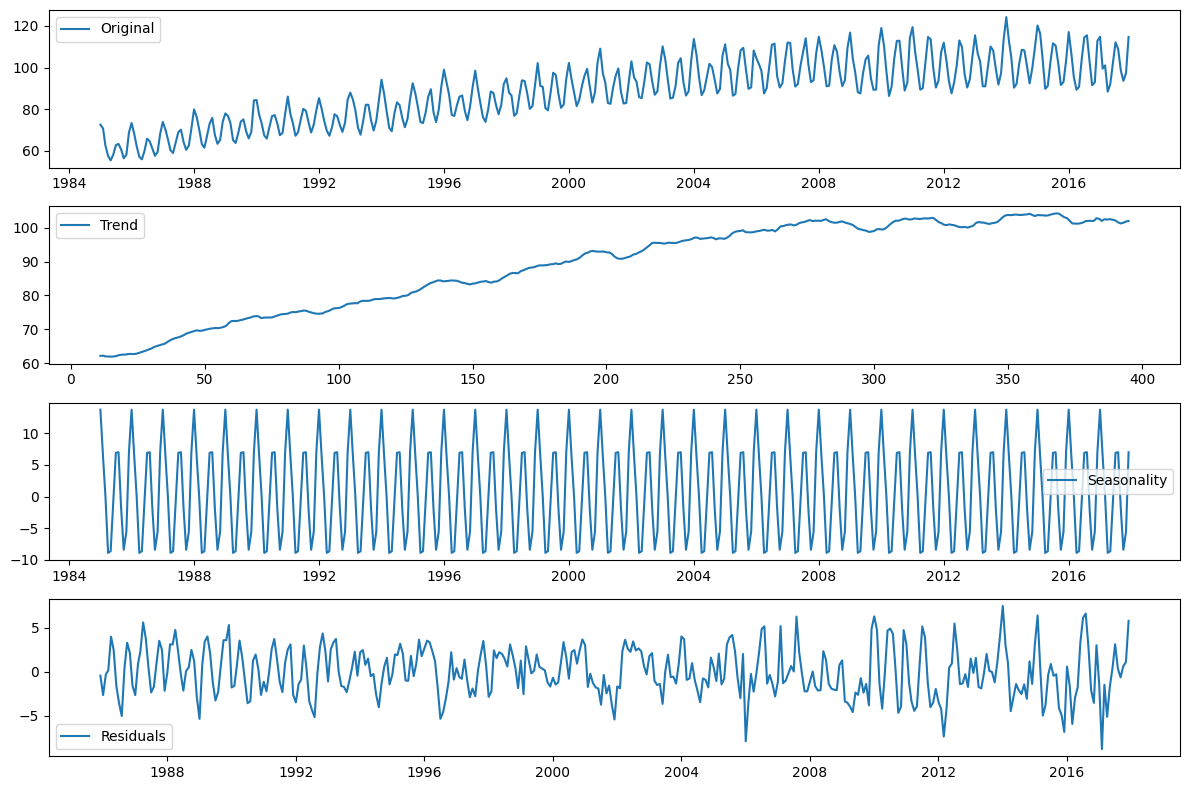

In [143]:
plt.figure(figsize=(12,8))

# Plotting the original time series (if available)
plt.subplot(411)
plt.plot(df['production'], label='Original')
plt.legend(loc='best')

# Plotting the trend component
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

# Plotting the seasonal component
plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

# Plotting the residual component
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

They look pretty well. The trend looks like an increasing curve, the seasonality looks like a sin with two peaks per year and the residual looks like a white noise. 

# **TSA Decomposition**

Now we can compare our results to an already existing method using the tsa library.

In [144]:
# Decomposition using statsmodels
statsmodels = seasonal_decompose(df['production'], model='additive', period=12)

# Calculate the MSE for each component
trend_mse = mean_squared_error(manual_decomposition['trend'][~np.isnan(manual_decomposition['trend']) & ~np.isnan(statsmodels.trend)], 
                               statsmodels.trend[~np.isnan(manual_decomposition['trend']) & ~np.isnan(statsmodels.trend)])
seasonal_mse = mean_squared_error(manual_decomposition['seasonal'][~np.isnan(manual_decomposition['seasonal']) & ~np.isnan(statsmodels.seasonal)], 
                                  statsmodels.seasonal[~np.isnan(manual_decomposition['seasonal']) & ~np.isnan(statsmodels.seasonal)])
resid_mse = mean_squared_error(manual_decomposition['resid'][~np.isnan(manual_decomposition['resid']) & ~np.isnan(statsmodels.resid)], 
                               statsmodels.resid[~np.isnan(manual_decomposition['resid']) & ~np.isnan(statsmodels.resid)])

# Print the results
print(f'Trend MSE: {trend_mse}')
print(f'Seasonal MSE: {seasonal_mse}')
print(f'Resid MSE: {resid_mse}')

Trend MSE: 1.4006108755555988
Seasonal MSE: 0.36072208413761536
Resid MSE: 1.080898471069933


Results obtained :
``` bash
Trend MSE: 1.3973945976726034
Seasonal MSE: 0.4021200028781762
Resid MSE: 1.0861514434125257
```

As we computed the average squared error between our decomposition and the one from the tsa library, we can see we have pretty similar results because of the small MSE values.

# **Check Stationarity**

We based our notebook reflexion on a well known article from [this towarddatascience article](https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788).
We also know the next step is to check the stationarity of the data, so lets do that.

One common method to check if a time series data is stationary is by using the Augmented Dickey Fuller Test (ADF Test). Essentially, this test is used to detect the presence of unit root in the series. If the unit root is not present, it suggests that the time series data is stationary, and we can reject the null hypothesis.

In [145]:
def ADF_test(dataframe):
    adf_result = adfuller(dataframe)
    print('ADF: %f' % adf_result[0])
    print('P-value: %f' % adf_result[1])
    print('Critical Values:')
    for key, value in adf_result[4].items():
        print('\t%s: %.3f' % (key, value))

In [146]:
ADF_test(df['production'])

ADF: -2.581844
P-value: 0.096808
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


We can't reject the null hypothesis with a = 5%, hence the data is stationary.

## Convert to stationary

We will use the differencing method to convert our data to stationary as we saw in [this article](https://otexts.com/fpp2/stationarity.html).

In [147]:
diff = df['production']-df['production'].shift(1)
diff_season = diff - diff.shift(12)
diff_season = diff_season.dropna(inplace=False)

In [148]:
ADF_test(diff_season)

ADF: -8.164004
P-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


Now we can reject the hypothesis because the p-value (0) is less than 5%, hence the data is now stationary and we can keep going!

# **Split the data**

Now we are going to split the data between train and test. Test will be one year befour the end of the data. Since the data ends on january 2018, we will split from january 2017. 

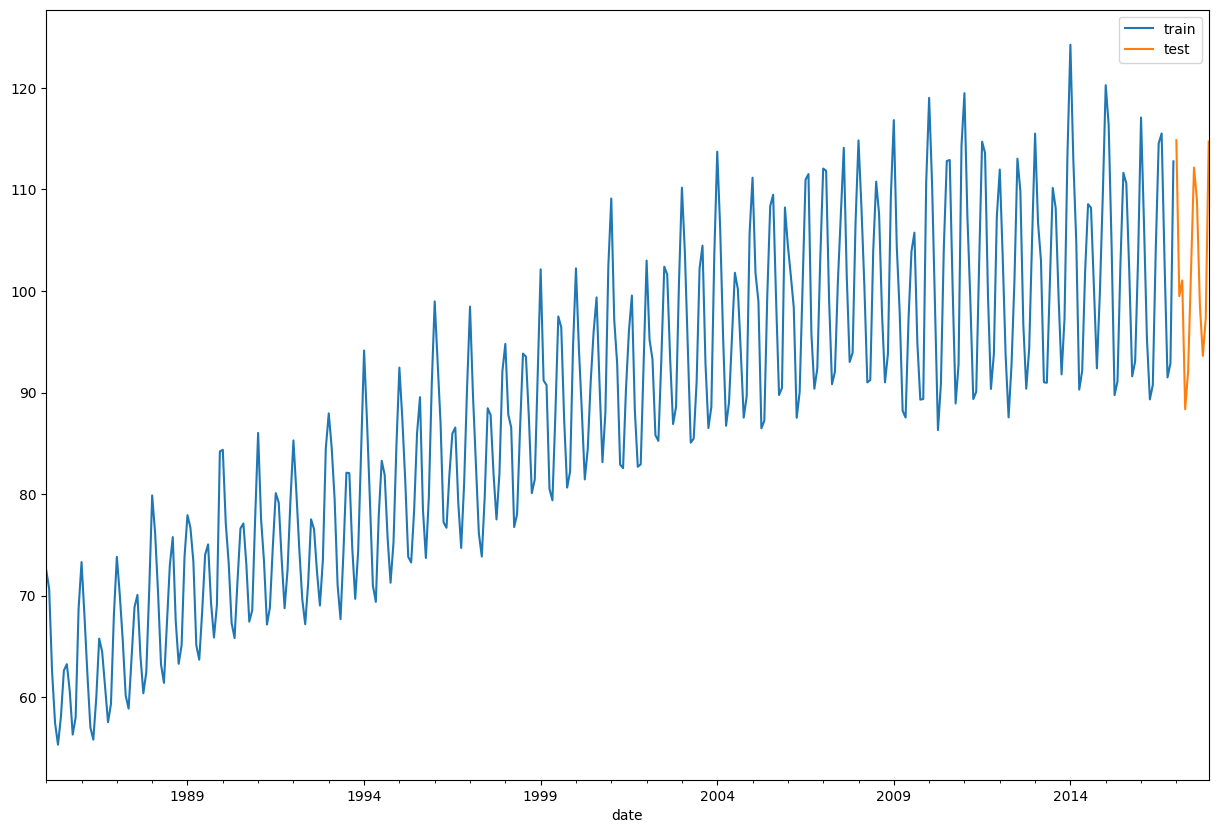

In [173]:
df_set = df['production']

df_train = df_set[df_set.index<'01-01-2017']
df_test = df_set[df_set.index>='01-01-2017']

def plot_ts(s_train=df_train, s_test=df_test, s_pred=None, ax=None, fit_params=None):
    plt.figure(figsize=(15, 10))
    s_train.plot(label='train', ax=ax)
    s_test.plot(label='test', ax=ax)
    if isinstance(s_pred, pd.Series):
        s_pred.plot(label='predict', ax=ax)
        print("found prediction")
    if ax is not None:
        ax.legend(loc='upper right')
        ax.set_title(fit_params)
    else:
        plt.legend()
plot_ts()

Now that we have split the data, we can start to make predictions.

# **Prediction**

The two main forecasting models we will use will be Exponential Smoothing and ARMA/ARIMA.  

Again, we checked on [this towarddatascience article](https://towardsdatascience.com/time-series-in-python-exponential-smoothing-and-arima-processes-2c67f2a52788) for information on different prediction models:

**Simple Exponential Smoothing**
>When to use?
Few data points, Irregular data, No seasonality or trend.
>Math behind
Just keep in mind that SES only has one component called level

**Holt’s Linear Smoothing**
>When to use?
Trend in data, No seasonality.

>Math behind
The forecast is made of a level component and a trend component.

**Holt’s Damped Trend**
>The problem with Holt’s Linear trend method is that the trend is constant in the future, increasing or decreasing indefinitely. For long forecast horizons, this can be problematic.

>When to use?
Data has a trend. Use the multiplicative version, unless the data has been logged before.

**ARIMA**
ARIMA models (which include ARMA, AR and MA models) are a general class of models to forecast stationary time series. ARIMA models are made of three parts:

- A weighted sum of lagged values of the series (Auto-regressive (AR) part)
- A weighted sum of lagged forecasted errors of the series (Moving-average (MA) part)
- A difference of the time series (Integrated (I) part)


Those reflexions made us choose the `Exponential` and `ARMA/ARIMA` models as predictions.

# Exponential Smooting

***Import the libraries***

In [76]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

Concerning the exponentil smoothing we can try the simple exponential and the triple exponential (HWES). 

Lets start by creating usefull functions.

In [129]:
prediction = {}
evaluation = {}

def evaluate(ytrue, ypred):
    scores = {
        'mae': mean_absolute_error(ytrue, ypred),
        'rmse': np.sqrt(mean_squared_error(ytrue, ypred)),
        'r2': r2_score(ytrue, ypred),
        'mape': mean_absolute_percentage_error(ytrue, ypred)
    }
    return scores

In [180]:
def ts_one_step_forecast(model, model_abbr, model_params={}, fit_params={}, ax=None):
    # rolling forecast
    ypred = list()
    for t in tqdm(range(len(df_test))):
        temp_train = df[:len(df_train)+t]
        m = model(temp_train, **model_params)
        fit = m.fit(**fit_params)
        predictions = fit.predict(start=len(temp_train), end=len(temp_train))   

        ypred = ypred + [predictions]                                            

    # save result
    ypred = pd.concat(ypred)

    prediction[model_abbr] = ypred
    evaluation[model_abbr] = evaluate(df_test, ypred)
    #print(ypred)
    # show result
    plot_ts(s_pred=ypred, ax=ax, fit_params=fit_params)
    
    return fit

### **Simple Exponential Smoothing**

  0%|          | 0/12 [00:00<?, ?it/s]c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
  8%|▊         | 1/12 [00:00<00:02,  4.78it/s]c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 17%|█▋        | 2/12 [00:00<00:01,  6.67it/s]c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 25%|██▌       | 3/12 [00:00<00:01,  5.71it/s]c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWar

2017-01-01    112.7694
2017-02-01    114.8505
2017-03-01     99.4901
2017-04-01    101.0396
2017-05-01     88.3530
2017-06-01     92.0805
2017-07-01    102.1532
2017-08-01    112.1538
2017-09-01    108.9312
2017-10-01     98.6154
2017-11-01     93.6137
2017-12-01     97.3359
Freq: MS, dtype: float64
found prediction


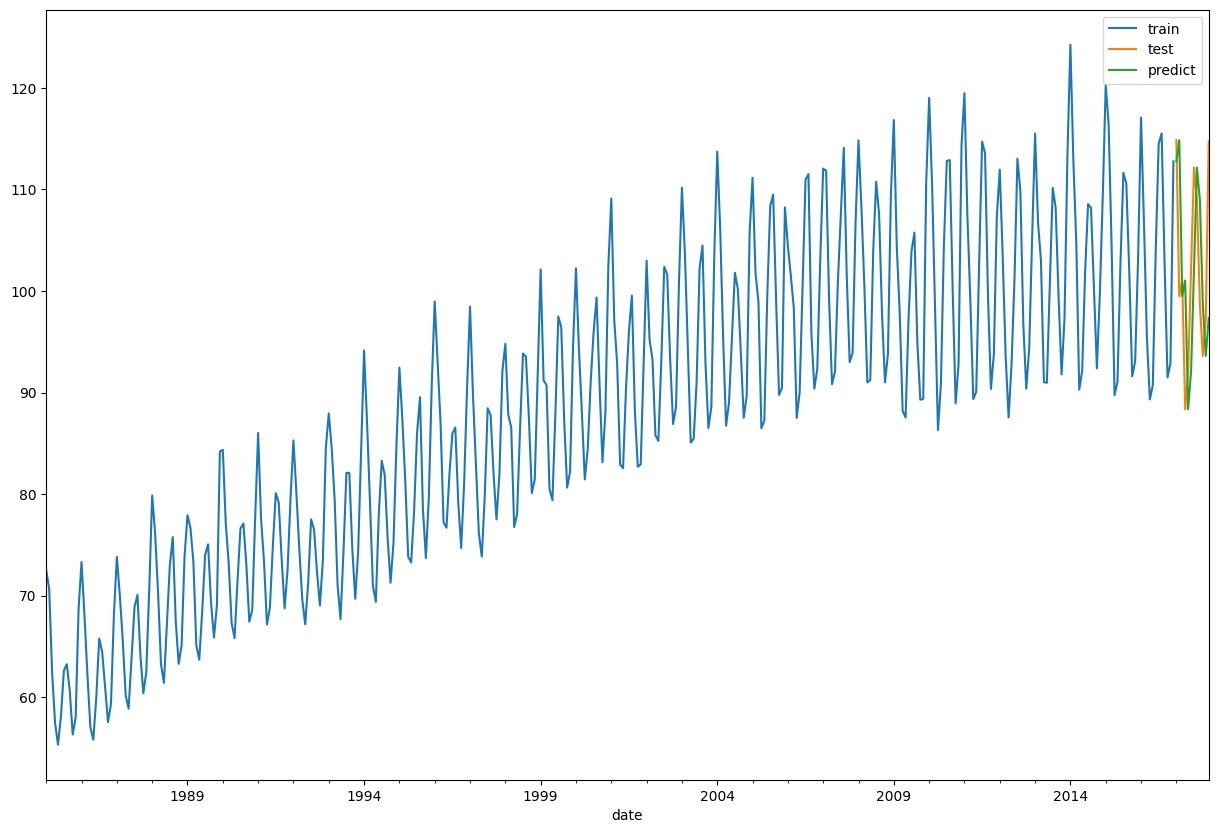

In [179]:
fit_params = {'optimized': True}
fit_ses = ts_one_step_forecast(SimpleExpSmoothing, 'SES', fit_params=fit_params)
#fit_ses.params

Results zommed in for simple exponential smoothing :

<img src="Exponential_01.png"
     width = 400 />

### **Triple Exponential Smoothing (HWES)**

  0%|          | 0/13 [00:00<?, ?it/s]c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
  8%|▊         | 1/13 [00:01<00:19,  1.62s/it]c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 15%|█▌        | 2/13 [00:03<00:16,  1.53s/it]c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 23%|██▎       | 3/13 [00:04<00:14,  1.50s/it]c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWar

{'smoothing_level': 0.9944877371843303,
 'smoothing_trend': 0.0021931651933000344,
 'smoothing_seasonal': 0.005462774683691239,
 'damping_trend': nan,
 'initial_level': 101.65437839683631,
 'initial_trend': 0.20091535804587934,
 'initial_seasons': array([ 0.50831769, -1.26844091,  1.05396525]),
 'use_boxcox': True,
 'lamda': 1.1477439576809765,
 'remove_bias': False}

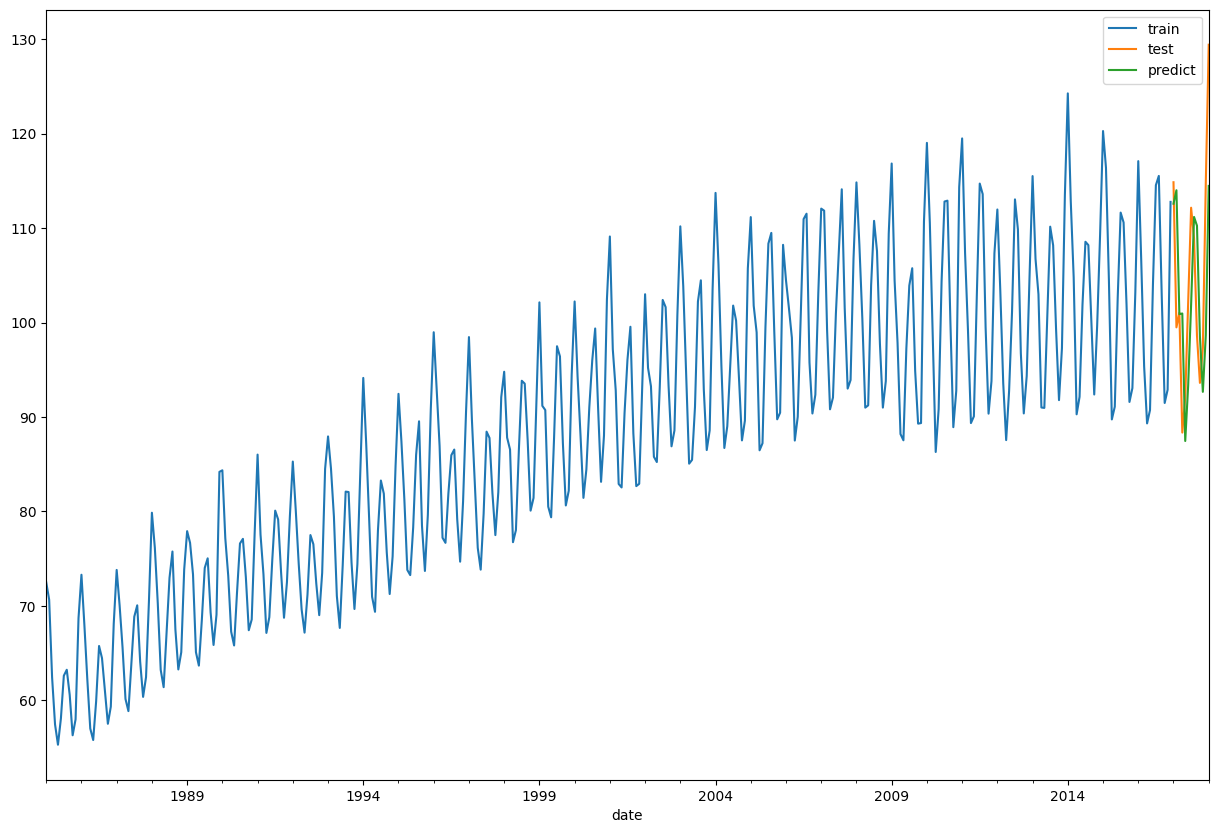

In [99]:
model_params = {
    'seasonal_periods': 3, 
    'trend': 'add',
    'seasonal': 'add', 
    'use_boxcox': True, 
    'initialization_method': "estimated"
}
fit_params = {'optimized': True}
fit_hwes = ts_one_step_forecast(ExponentialSmoothing, 'HWES', model_params=model_params, fit_params=fit_params)
fit_hwes.params

Results zommed in for triple exponential smoothing :

<img src="Exponential_02.png"
     width = 400 />

# ARMA/ARIMA

***Import the libraries***

In [195]:
from statsmodels.tsa.arima.model import ARIMA
from math import sqrt

### **ARMA**

In [192]:
ARMA_model = ARIMA(df_train,order=(3,0,4)).fit(method_kwargs={"warn_convergence": False})

c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


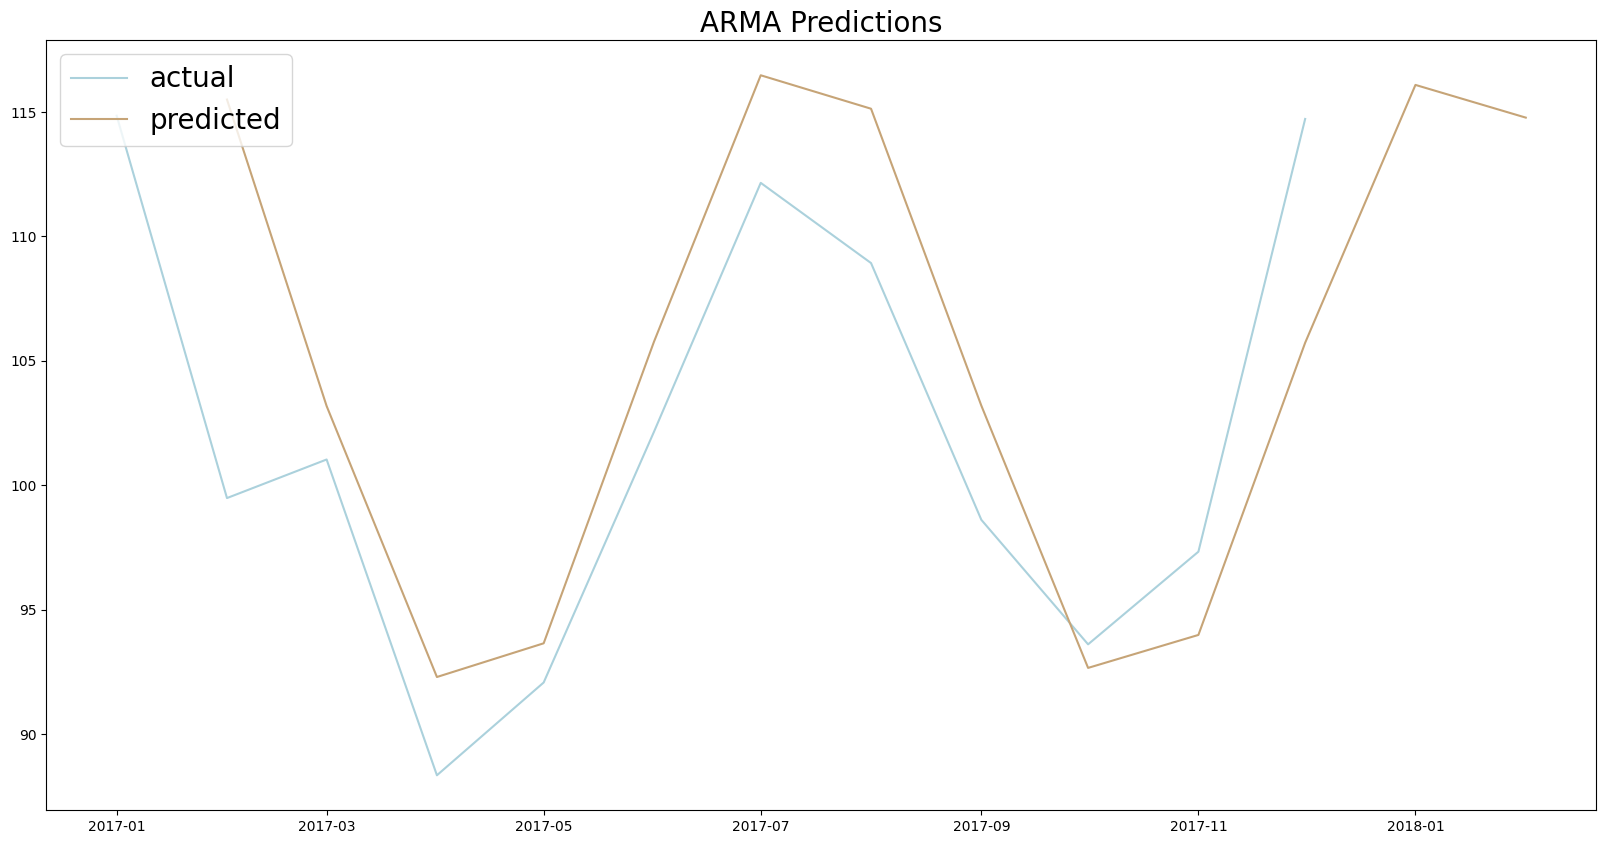

In [193]:
# generate predictions
df_pred = ARMA_model.predict(start=385, end=397)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARMA Predictions', fontsize=20)
plt.plot(df_test, label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

In [199]:
rmse = sqrt(mean_squared_error(df_test, df_pred.iloc[:-1]))
print("RMSE:", round(rmse,2))

RMSE: 7.42


### **ARIMA**

In [200]:
ARIMA_model = ARIMA(df_train,order=(3,1,4)).fit(method_kwargs={"warn_convergence": False})

c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\antoi\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


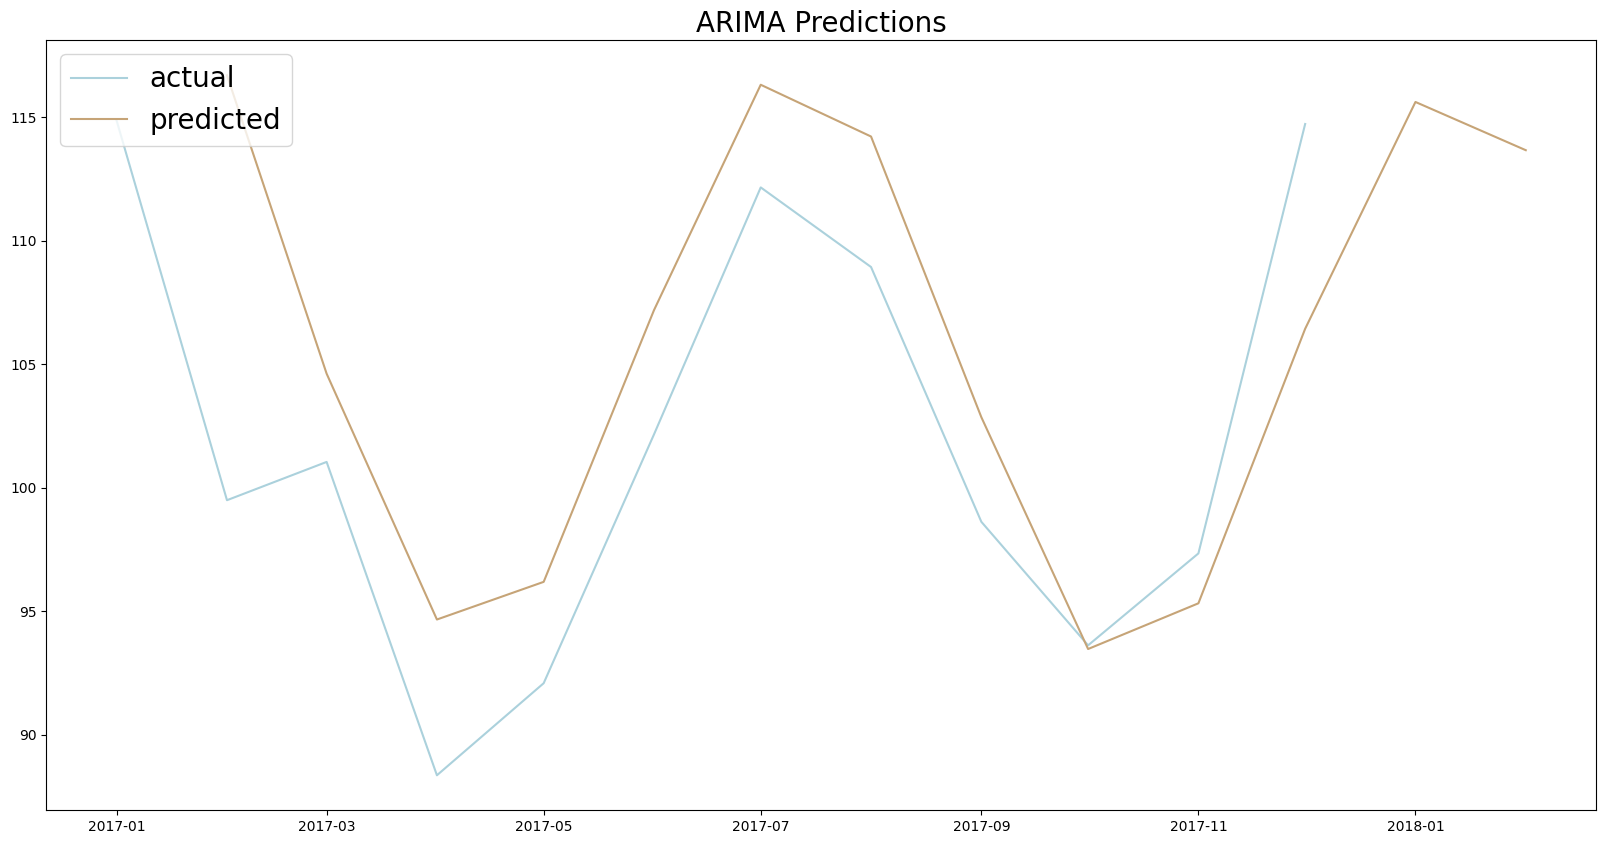

In [201]:
# generate predictions
df_pred = ARIMA_model.predict(start=385, end=397)
# plot actual vs. predicted
fig = plt.figure(figsize=(20, 10))
plt.title('ARIMA Predictions', fontsize=20)
plt.plot(df_test, label='actual', color='#ABD1DC')
plt.plot(df_pred, label='predicted', color='#C6A477')
plt.legend(fontsize =20, loc='upper left')

In [202]:
rmse = sqrt(mean_squared_error(df_test, df_pred.iloc[:-1]))
print("RMSE:", round(rmse,2))

RMSE: 7.72


# Summaries

In [203]:
fit_ses.summary()

Dep. Variable:,production,No. Observations:,395
Model:,SimpleExpSmoothing,SSE,23303.764
Optimized:,True,AIC,1614.606
Trend:,None,BIC,1622.564
Seasonal:,None,AICC,1614.709
Seasonal Periods:,None,Date:,"Tue, 26 Dec 2023"
Box-Cox:,False,Time:,15:15:19
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,1.0000000,alpha,True
initial_level,72.504780,l.0,True


In [204]:
fit_hwes.summary()

Dep. Variable:,production,No. Observations:,396
Model:,ExponentialSmoothing,SSE,23492.230
Optimized:,True,AIC,1630.872
Trend:,Additive,BIC,1658.742
Seasonal:,Additive,AICC,1631.339
Seasonal Periods:,3,Date:,"Tue, 26 Dec 2023"
Box-Cox:,True,Time:,15:16:39
Box-Cox Coeff.:,1.14774,,
,coeff,code,optimized
smoothing_level,0.9944877,alpha,True
smoothing_trend,0.0021932,beta,True


In [205]:
ARMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  384
Model:                 ARIMA(3, 0, 4)   Log Likelihood                -994.798
Date:                Tue, 26 Dec 2023   AIC                           2007.597
Time:                        15:16:50   BIC                           2043.153
Sample:                    01-01-1985   HQIC                          2021.700
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.3194    171.205      0.516      0.606    -247.237     423.876
ar.L1          1.9942      0.007    299.304      0.000       1.981       2.007
ar.L2         -1.9836      0.011   -181.611      0.000      -2.005      -1.962
ar.L3          0.9892      0.006    164.874      0.000       0.977       1.001
ma.L1         -1.1876      0.050    -23.914      0.000      -1.285      -1.090
ma.L2          0.7362      0.079      9.261      0.000       0.580       0.892
ma.L3          0.0562      0.080      0.706      0.480      -0.100       0.212
ma.L4         -0.3904      0.057     -6.875      0.000      -0.502      -0.279
sigma2         9.9079      0.677     14.644      0.000       8.582      11.234
===================================================================================
Ljung-Box (L1) (Q):                   1.33   Jarque-Bera (JB):                22.40
Prob(Q):                              0.25   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.38
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [206]:
ARIMA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  384
Model:                 ARIMA(3, 1, 4)   Log Likelihood                -987.275
Date:                Tue, 26 Dec 2023   AIC                           1990.550
Time:                        15:16:59   BIC                           2022.134
Sample:                    01-01-1985   HQIC                          2003.078
                         - 12-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7493      0.122     14.346      0.000       1.510       1.988
ar.L2         -1.7458      0.122    -14.346      0.000      -1.984      -1.507
ar.L3          0.7488      0.121      6.191      0.000       0.512       0.986
ma.L1         -1.9958      0.132    -15.160      0.000      -2.254      -1.738
ma.L2          2.0477      0.213      9.629      0.000       1.631       2.465
ma.L3         -1.1173      0.208     -5.381      0.000      -1.524      -0.710
ma.L4          0.1199      0.097      1.230      0.219      -0.071       0.311
sigma2        10.6314      0.845     12.576      0.000       8.974      12.288
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                18.11
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                             0.12
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""